In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
input = Input((512, 512, 3))

conv1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(input)
conv1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

pool1.shape

TensorShape([None, 256, 256, 64])

In [ ]:
conv2 = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(pool1)
conv2 = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)

pool2.shape

TensorShape([None, 128, 128, 128])

In [ ]:
conv3 = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(pool2)
conv3 = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

pool3.shape

TensorShape([None, 64, 64, 256])

In [ ]:
conv4 = Conv2D(512, (3,3), padding = 'same', activation = 'relu')(pool3)
conv4 = Conv2D(512, (3,3), padding = 'same', activation = 'relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(conv4)

pool4.shape

TensorShape([None, 32, 32, 512])

In [ ]:
conv5 = Conv2D(1024, (3,3), padding = 'same', activation = 'relu')(pool4)
conv5 = Conv2D(1024, (3,3), padding = 'same', activation = 'relu')(conv5)

conv5.shape

TensorShape([None, 32, 32, 1024])

In [ ]:
convUp = Conv2DTranspose(512, (2,2), strides = (2,2), padding = 'same', activation = 'relu')(conv5)
convUp = Concatenate()([convUp, conv4])
convUp = Conv2D(512, (3,3), padding = 'same', activation = 'relu')(convUp)
convUp = Conv2D(512, (3,3), padding = 'same', activation = 'relu')(convUp)


convUp.shape

TensorShape([None, 64, 64, 512])

In [ ]:
convUp = Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same', activation = 'relu')(convUp)
convUp = Concatenate()([convUp, conv3])
convUp = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(convUp)
convUp = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(convUp)


convUp.shape

TensorShape([None, 128, 128, 256])

In [ ]:
convUp = Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same', activation = 'relu')(convUp)
convUp = Concatenate()([convUp, conv2])
convUp = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(convUp)
convUp = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(convUp)


convUp.shape

TensorShape([None, 256, 256, 128])

In [ ]:
convUp = Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same', activation = 'relu')(convUp)
convUp = Concatenate()([convUp, conv1])
convUp = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(convUp)
convUp = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(convUp)


convUp.shape

TensorShape([None, 512, 512, 64])

In [ ]:
output = Conv2D(1, (1,1), activation = 'sigmoid')(convUp)
output.shape

model = Model(inputs = [input], outputs = [output])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

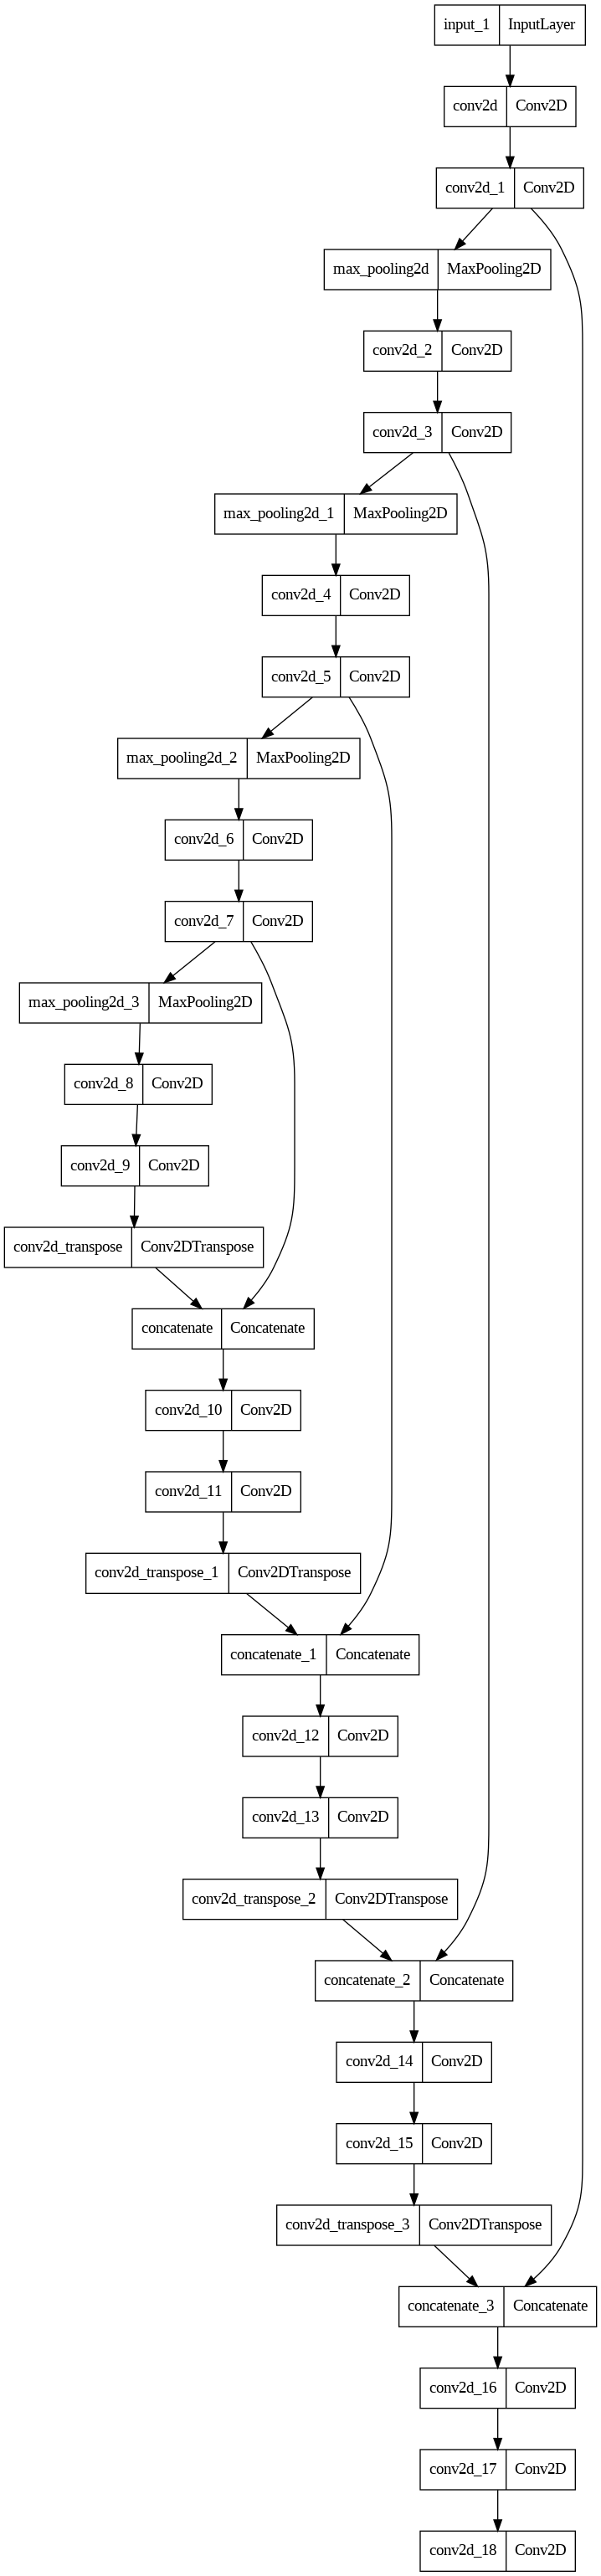

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

In [ ]:
#Data
import numpy as np
import os
import cv2

In [ ]:
input_path = os.listdir("../dataset/img/")
output_path = os.listdir("../dataset/mask/")

X =  np.zeros((len(input_path), 512, 512, 3), dtype = "uint8")
y =  np.zeros((len(output_path), 512, 512), dtype = "bool")

for i in range(len(input_path)):
    img_path = os.path.join("../dataset/img/", input_path[i])
    mask_path = os.path.join("../dataset/mask/", output_path[i])
    img = cv2.imread(img_path)
    mask =cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    X[i] = img
    y[i] = mask
    i = i + 1

print(img.shape)
print(mask.shape)
print(X.shape)
print(y.shape)


(512, 512, 3)
(512, 512)
(566, 512, 512, 3)
(566, 512, 512)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', save_freq = 'epoch')
history = model.fit(X, y, epochs=10, batch_size = 8, callbacks = [checkpoint])

NameError: ignored

In [ ]:
#model = tf.keras.models.load_model('model.31.h5')
#test = model.predict('dataset/img/CHNCXR_0001_0.png')

OSError: ignored